In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL.ImageColor import colormap

In [2]:
df = pd.read_csv('../data/processed/merged_data.csv', parse_dates=['timestamp'])
df.head()

,timestamp,btc_price,btc_volume,eth_price,eth_volume,fees,stablecoins_supply,defi_tvl,market_cap,volume,fng_value
0,2018-08-18,6566.715163,6.206194e+09,314.793253,2.930410e+09,8.0,15127992.0,367401.0,2.295305e+11,1.806076e+10,24
1,2018-08-19,6382.060591,5.616966e+09,293.176992,2.806352e+09,26.0,15127992.0,365249.0,2.152358e+11,1.523521e+10,27
2,2018-08-20,6475.494020,5.160365e+09,299.435123,2.503897e+09,8.0,15127992.0,363340.0,2.216411e+11,1.379505e+10,26
3,2018-08-21,6242.882438,5.578292e+09,271.061552,2.209797e+09,35.0,15127992.0,358941.0,2.092269e+11,1.344527e+10,19
4,2018-08-22,6467.271730,5.658517e+09,280.374717,2.099628e+09,42.0,15127992.0,316470.0,2.151441e+11,1.239502e+10,21


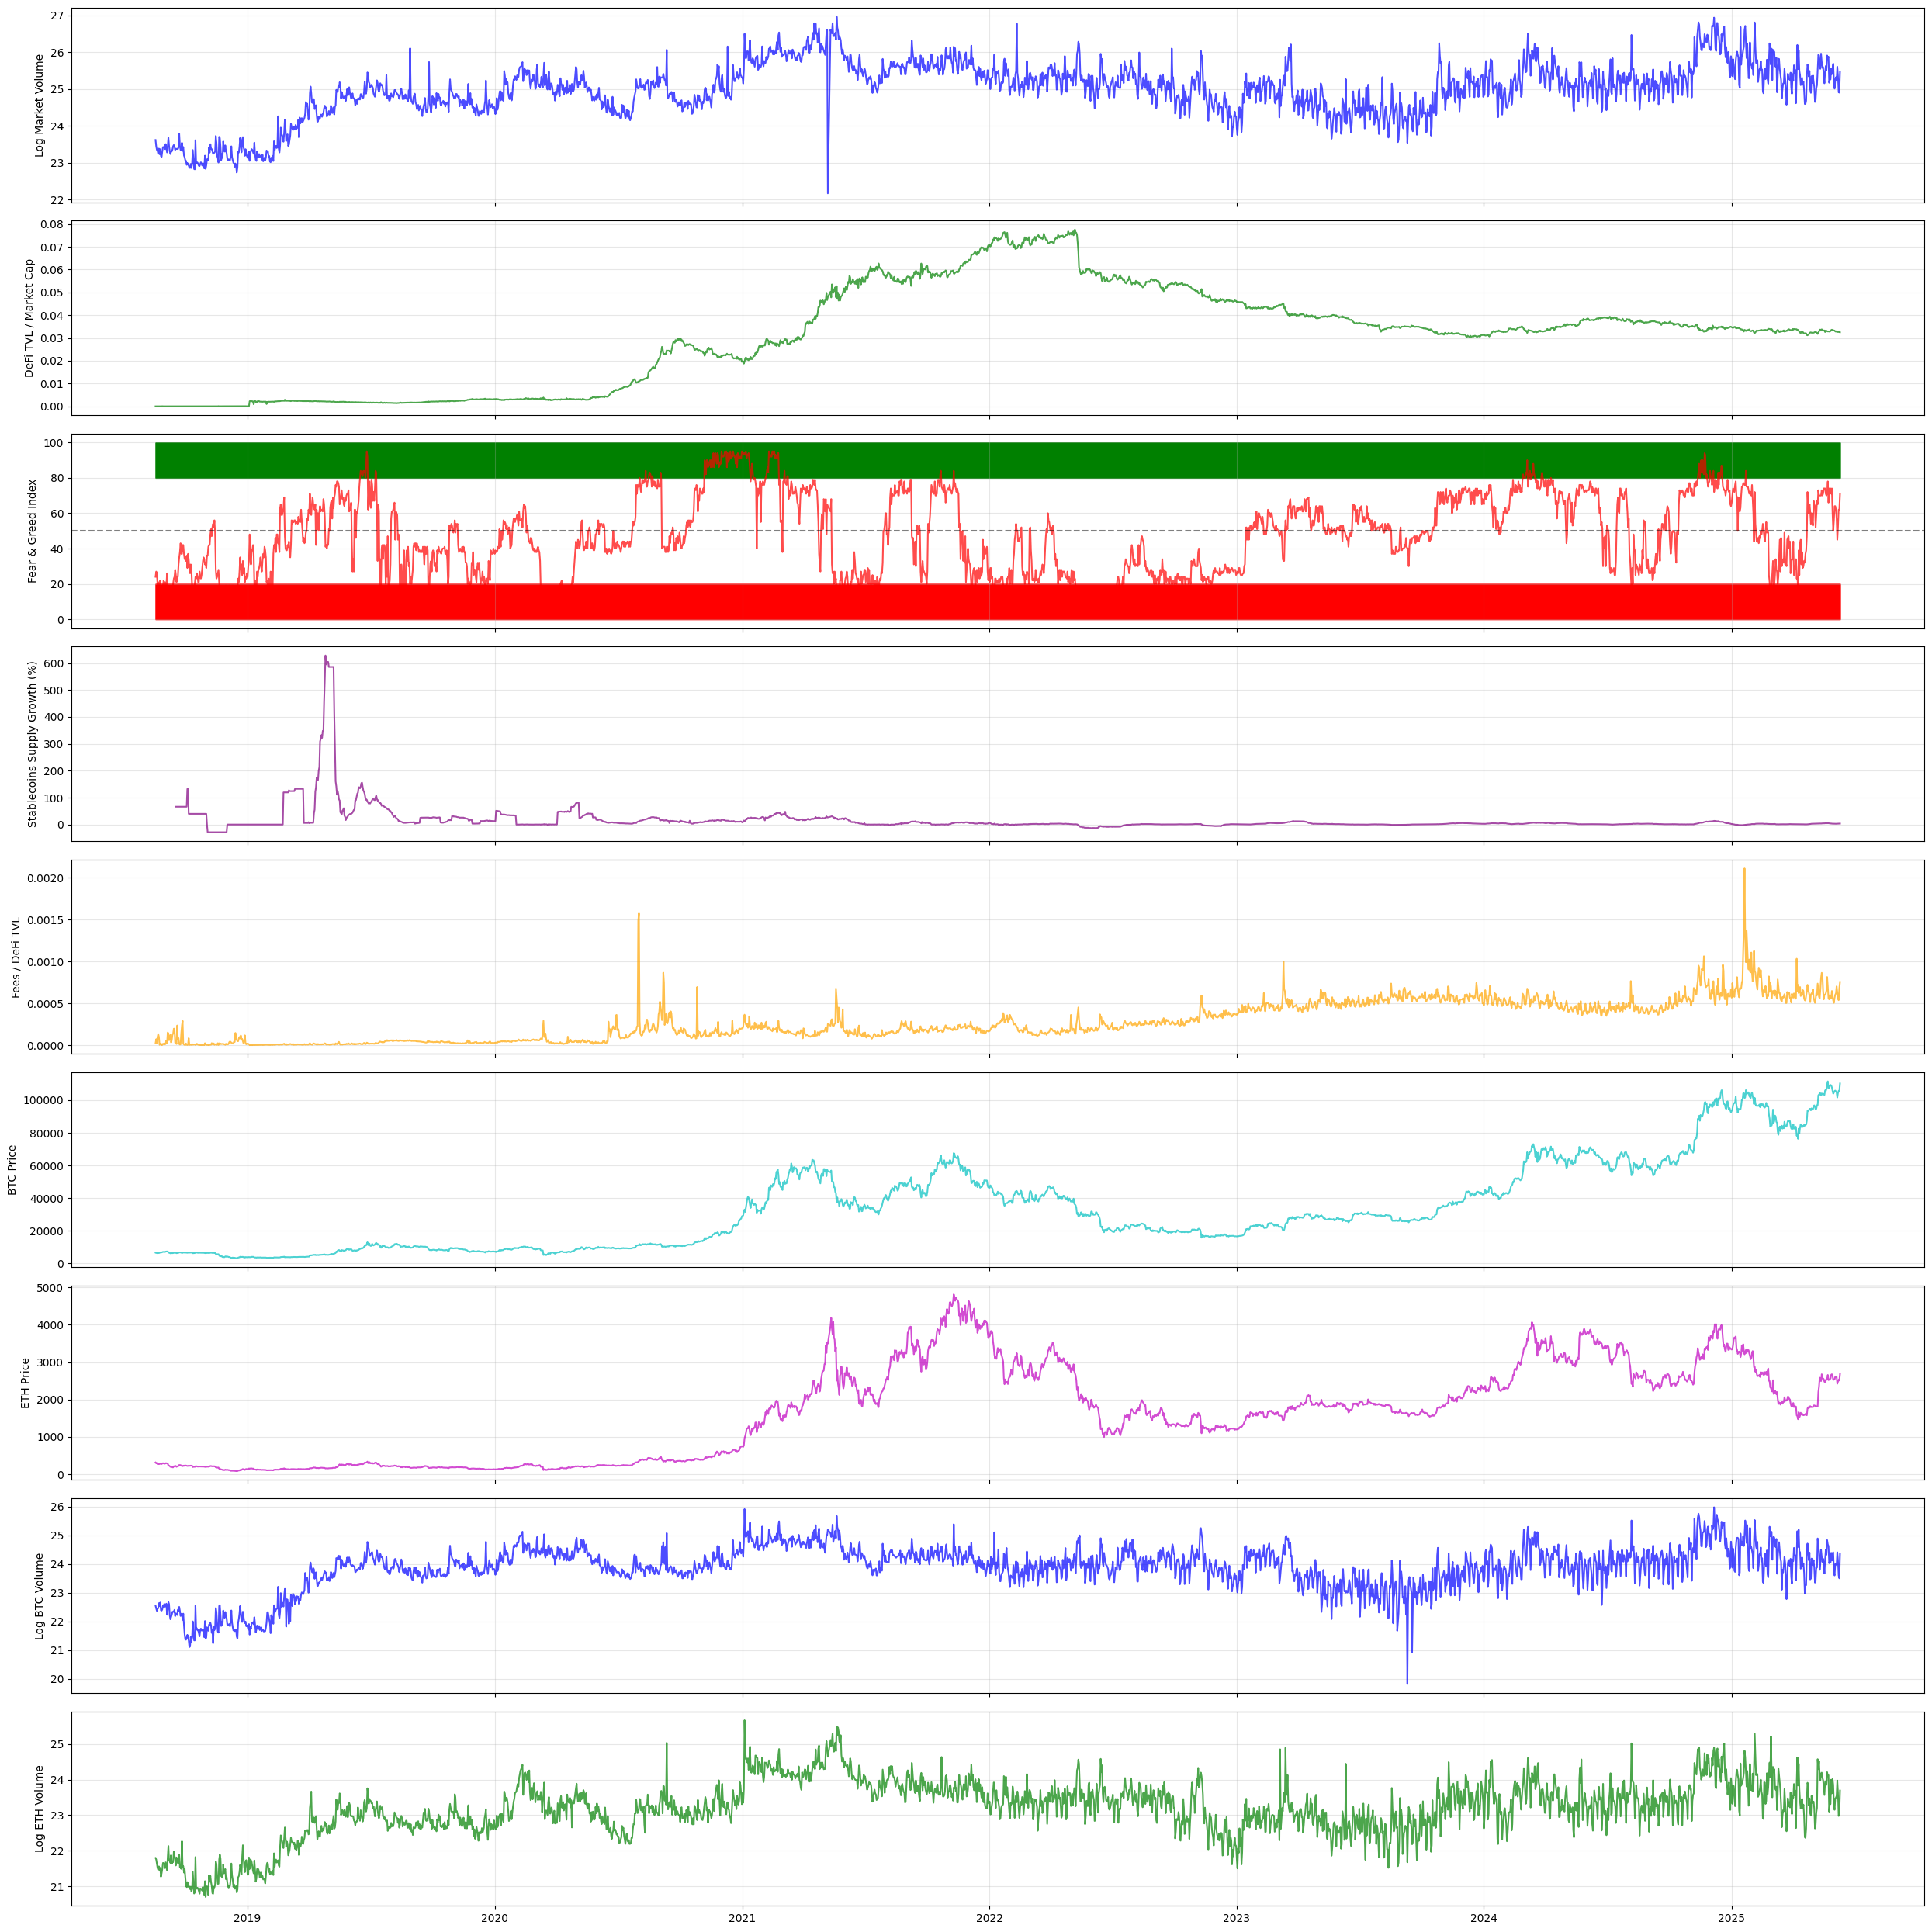

In [8]:
fig, axes = plt.subplots(9, 1, figsize=(25, 25), sharex=True)

axes[0].plot(df['timestamp'], np.log(df['volume']), 'b-', alpha=0.7)
axes[0].set_ylabel('Log Market Volume')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df['timestamp'], df['defi_tvl']/df['market_cap'], 'g-', alpha=0.7)
axes[1].set_ylabel('DeFi TVL / Market Cap')
axes[1].grid(True, alpha=0.3)

axes[2].plot(df['timestamp'], df['fng_value'], 'r-', alpha=0.7)
axes[2].axhline(50, color='k', linestyle='--', alpha=0.5)
axes[2].fill_between(df['timestamp'], 0, 20, color='red', label='Extreme Fear')
axes[2].fill_between(df['timestamp'], 80, 100, color='green', label='Extreme Greed')
axes[2].set_ylabel('Fear & Greed Index')
axes[2].grid(True, alpha=0.3)

stablecoins_growth = df['stablecoins_supply'].pct_change(30)
axes[3].plot(df['timestamp'], stablecoins_growth*100, 'purple', alpha=0.7)
axes[3].set_ylabel('Stablecoins Supply Growth (%)')
axes[3].grid(True, alpha=0.3)

axes[4].plot(df['timestamp'], df['fees'] / df['defi_tvl'], 'orange', alpha=0.7)
axes[4].set_ylabel('Fees / DeFi TVL')
axes[4].grid(True, alpha=0.3)

axes[5].plot(df['timestamp'], df['btc_price'], 'c-', alpha=0.7)
axes[5].set_ylabel('BTC Price')
axes[5].grid(True, alpha=0.3)

axes[6].plot(df['timestamp'], df['eth_price'], 'm-', alpha=0.7)
axes[6].set_ylabel('ETH Price')
axes[6].grid(True, alpha=0.3)

axes[7].plot(df['timestamp'], np.log(df['btc_volume']), 'b-', alpha=0.7)
axes[7].set_ylabel('Log BTC Volume')
axes[7].grid(True, alpha=0.3)

axes[8].plot(df['timestamp'], np.log(df['eth_volume']), 'g-', alpha=0.7)
axes[8].set_ylabel('Log ETH Volume')
axes[8].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [4]:
print(df.corr())

                    timestamp  btc_price  btc_volume  eth_price  eth_volume  \
timestamp            1.000000   0.797898    0.230838   0.720822    0.246473   
btc_price            0.797898   1.000000    0.426322   0.810662    0.463402   
btc_volume           0.230838   0.426322    1.000000   0.319334    0.829736   
eth_price            0.720822   0.810662    0.319334   1.000000    0.436033   
eth_volume           0.246473   0.463402    0.829736   0.436033    1.000000   
fees                 0.807644   0.890790    0.355758   0.724940    0.363765   
stablecoins_supply   0.966984   0.878061    0.233815   0.809722    0.290733   
defi_tvl             0.635850   0.784952    0.294004   0.940789    0.405510   
market_cap           0.811847   0.976325    0.396851   0.910589    0.460216   
volume               0.308115   0.574181    0.876776   0.529207    0.881928   
fng_value            0.229144   0.359036    0.284477   0.237911    0.225755   

                        fees  stablecoins_supply  d

In [18]:
import pandas as pd
import numpy as np


anomaly_df = pd.DataFrame(index=df.index)

# A. Price Shocks (separating drops and pumps)
for col in ['btc_price', 'eth_price']:
    change = df[col].pct_change()
    anomaly_df[f'{col}_crash'] = (change < change.quantile(0.05)).astype(int)
    anomaly_df[f'{col}_pump'] = (change > change.quantile(0.95)).astype(int)

# B. Volume Shock (spikes only, as a drop in volume is not typically a crisis)
for col in ['volume', 'btc_volume', 'eth_volume']:
    log_col = np.log(df[col] + 1) # Adding 1 to avoid log(0)
    zscore = (log_col - log_col.mean()) / log_col.std()
    anomaly_df[f'{col}_spike'] = (zscore > 3).astype(int) # 3-sigma event

# C. TVL Shock (separating drops and pumps)
tvl_change = df['defi_tvl'].pct_change()
anomaly_df['tvl_drop'] = (tvl_change < tvl_change.quantile(0.05)).astype(int)
anomaly_df['tvl_pump'] = (tvl_change > tvl_change.quantile(0.95)).astype(int)

# D. Fee Shock (spikes only)
fees_change = df['fees'].pct_change()
anomaly_df['fees_spike'] = (fees_change > fees_change.quantile(0.95)).astype(int)

# E. Sentiment
anomaly_df['extreme_fear'] = (df['fng_value'] < 20).astype(int)
anomaly_df['extreme_greed'] = (df['fng_value'] > 80).astype(int)


# --- Step 3: Finding Patterns (instead of simple summation) ---

# Pattern 1: "Panic Sell-off"
# (A price crash in BTC OR ETH + a total volume spike + extreme fear)
anomaly_df['panic_selloff_score'] = (
    anomaly_df[['btc_price_crash', 'eth_price_crash']].any(axis=1).astype(int) +
    anomaly_df['volume_spike'] +
    anomaly_df['extreme_fear']
)

# Pattern 2: "DeFi Stress"
# (TVL drop + fee spike)
anomaly_df['defi_stress_score'] = anomaly_df['tvl_drop'] + anomaly_df['fees_spike']


# --- Step 4: Outputting Results ---

print("--- Days with 'Panic Sell-off' Pattern (coincidence score >= 2) ---")
panic_days = anomaly_df[anomaly_df['panic_selloff_score'] >= 2]
print(panic_days[['btc_price_crash', 'eth_price_crash', 'volume_spike', 'extreme_fear', 'panic_selloff_score']].head(15))


print("\n--- Days with 'DeFi Stress' Pattern (2 features coincided) ---")
stress_days = anomaly_df[anomaly_df['defi_stress_score'] >= 2]
print(stress_days[['tvl_drop', 'fees_spike', 'defi_stress_score']].head(15))

--- Days with 'Panic Sell-off' Pattern (coincidence score >= 2) ---
     btc_price_crash  eth_price_crash  volume_spike  extreme_fear  \
3                  0                1             0             1   
19                 1                1             0             1   
22                 0                1             0             1   
55                 1                1             0             1   
95                 1                1             0             1   
97                 1                1             0             1   
99                 1                1             0             1   
101                1                1             0             1   
105                1                0             0             1   
108                1                0             0             1   
110                0                1             0             1   
111                1                1             0             1   
146                1               

In [21]:
panic_dates = panic_days.index
stress_dates = stress_days.index

overlapping_days = panic_dates.intersection(stress_dates)

print(f"Summary Panic Dates: {len(panic_dates)}")
print(f"Summary DeFi Stress Dates: {len(stress_dates)}")
print(f"Overlapping days: {len(overlapping_days)} days")

overlap_percentage = len(overlapping_days) / len(stress_days) * 100
print(f"Overlap percentage: {overlap_percentage:.1f}%")

Summary Panic Dates: 51
Summary DeFi Stress Dates: 19
Overlapping days: 2 days
Overlap percentage: 10.5%


In [31]:
df['is_panic_day'] = (anomaly_df['panic_selloff_score'] >= 2).astype(int)
df['is_defi_stress_day'] = (anomaly_df['defi_stress_score'] >= 2).astype(int)
df['is_pure_stress_day'] = ( (df['is_defi_stress_day'] == 1) & (df['is_panic_day'] == 0) ).astype(int)

look_forward_window = 5
df['panic_in_next_days'] = df['is_panic_day'].shift(-look_forward_window).rolling(window=look_forward_window, min_periods=1).max()


df_test = df.dropna(subset=['is_pure_stress_day', 'panic_in_next_days'])
df_test = df_test.assign(panic_in_next_days=df_test['panic_in_next_days'].astype(int))

contingency_table = pd.crosstab(df_test['is_pure_stress_day'], df_test['panic_in_next_days'])
print("Rows: Was there a 'DeFi Stress' event? (0=No, 1=Yes)")
print("Columns: Was there a 'Panic' event in the next 5 days? (0=No, 1=Yes)")
print(contingency_table)

Rows: Was there a 'DeFi Stress' event? (0=No, 1=Yes)
Columns: Was there a 'Panic' event in the next 5 days? (0=No, 1=Yes)
panic_in_next_days     0    1
is_pure_stress_day           
0                   2283  182
1                     11    6


In [32]:
# Chi squared test
if contingency_table.shape == (2, 2):
    from scipy.stats import chi2_contingency
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    print(f"Chi-squared statistic: {chi2}, p-value: {p_value}")

    alpha = 0.05
    if p_value < alpha:
        print("Reject the null hypothesis: DeFi Stress events are associated with Panic events.")
    else:
        print("Fail to reject the null hypothesis: No significant association found.")

print("Contingency table shape:", contingency_table.shape)

Chi-squared statistic: 15.011799098224916, p-value: 0.00010684107783420618
Reject the null hypothesis: DeFi Stress events are associated with Panic events.
Contingency table shape: (2, 2)


In [33]:
# Fisher exact test
from scipy.stats import fisher_exact

if contingency_table.shape == (2, 2):
    odds_ratio, p_value = fisher_exact(contingency_table, alternative='greater')
    print(f'Odds Ratio: {odds_ratio}, p-value: {p_value}')

    print(f"Odds Ratio Interpretation: {odds_ratio:.2f} times more likely to have a Panic event after a DeFi Stress event.")

    alpha = 0.05
    if p_value < alpha:
        print(f"Reject the null hypothesis: DeFi Stress events are associated with Panic events (p-value: {p_value:.4f}).")
    else:
        print(f"Fail to reject the null hypothesis: No significant association found (p-value: {p_value:.4f}).")

Odds Ratio: 6.842157842157842, p-value: 0.0010647446759899334
Odds Ratio Interpretation: 6.84 times more likely to have a Panic event after a DeFi Stress event.
Reject the null hypothesis: DeFi Stress events are associated with Panic events (p-value: 0.0011).


In [34]:
df['target'] = df['is_pure_stress_day'].shift(-1)
df.to_csv('../data/processed/df_with_anomalies.csv', index=False)